## Analiza cech wyróżniających gatunek *jazz*

Skrypt filtruje dane tak, aby:
- **`df_target`** zawierał próbki jazzu,
- **`df_rest`** próbki innych gatunków.

Z listy cech numerycznych obliczana jest wartość **d Cohena** dla każdej cechy - miernik różnicy między jazzem a resztą zbioru.  
Na podstawie największych wartości bezwzględnych |d| wybierane jest **TOP 15 cech**, które najlepiej odróżniają jazz.

---

d Cohena to miara wielkości efektu określająca znormalizowaną różnicę średnich między dwiema grupami.

Wzór:

$$
d = \frac{\bar{x}_1 - \bar{x}_2}{s_p}
$$

gdzie:

- średnia w grupie pierwszej  
  $$
  \bar{x}_1
  $$

- średnia w grupie drugiej  
  $$
  \bar{x}_2
  $$

- wspólne odchylenie standardowe (*pooled standard deviation*):

$$
s_p = \sqrt{
\frac{(n_1 - 1)s_1^{2} + (n_2 - 1)s_2^{2}}{n_1 + n_2 - 2}
}
$$

a dodatkowo:

- liczności obu grup  
  $$
  n_1,\; n_2
  $$

- odchylenia standardowe obu grup  
  $$
  s_1,\; s_2
  $$


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


# Podaj poprawną ścieżkę do plików CSV
df3 = pd.read_csv("lib/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv")
df30 = pd.read_csv("lib/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv")


In [2]:

sns.set(style="whitegrid")


target_genre = "jazz"
label_col = "label"
TOP = 15  # ile top cech chcemy wyświetlić
n_cols = 3  # liczba kolumn w gridzie

# Przygotowanie danych 
df_target = df30[df30[label_col] == target_genre]
df_rest = df30[df30[label_col] != target_genre]

numeric_cols = df30.select_dtypes(include=['float64','int64']).columns.tolist()
if label_col in numeric_cols:
    numeric_cols.remove(label_col)

#  Cohen's d dla każdej cechy 
results = []
for feat in numeric_cols:
    x1 = df_target[feat].dropna()
    x2 = df_rest[feat].dropna()
    
    mean1, mean2 = x1.mean(), x2.mean()
    std1, std2 = x1.std(), x2.std()
    n1, n2 = len(x1), len(x2)
    
    pooled_std = np.sqrt(((n1-1)*std1**2 + (n2-1)*std2**2)/(n1+n2-2))
    d = (mean1 - mean2)/pooled_std if pooled_std>0 else 0
    
    results.append({"feature": feat, "cohens_d": d})

res_df = pd.DataFrame(results)
res_df["abs_d"] = res_df["cohens_d"].abs()
res_df = res_df.sort_values("abs_d", ascending=False).reset_index(drop=True)

top_features = res_df.head(TOP)["feature"].tolist()
print("Top cechy wyróżniające jazz dla 30s pomiarów:", top_features)

Top cechy wyróżniające jazz dla 30s pomiarów: ['chroma_stft_mean', 'mfcc7_var', 'perceptr_var', 'mfcc1_mean', 'mfcc20_var', 'mfcc6_var', 'rms_mean', 'mfcc19_var', 'mfcc5_var', 'zero_crossing_rate_mean', 'mfcc8_var', 'mfcc4_var', 'mfcc16_var', 'mfcc18_var', 'spectral_centroid_mean']


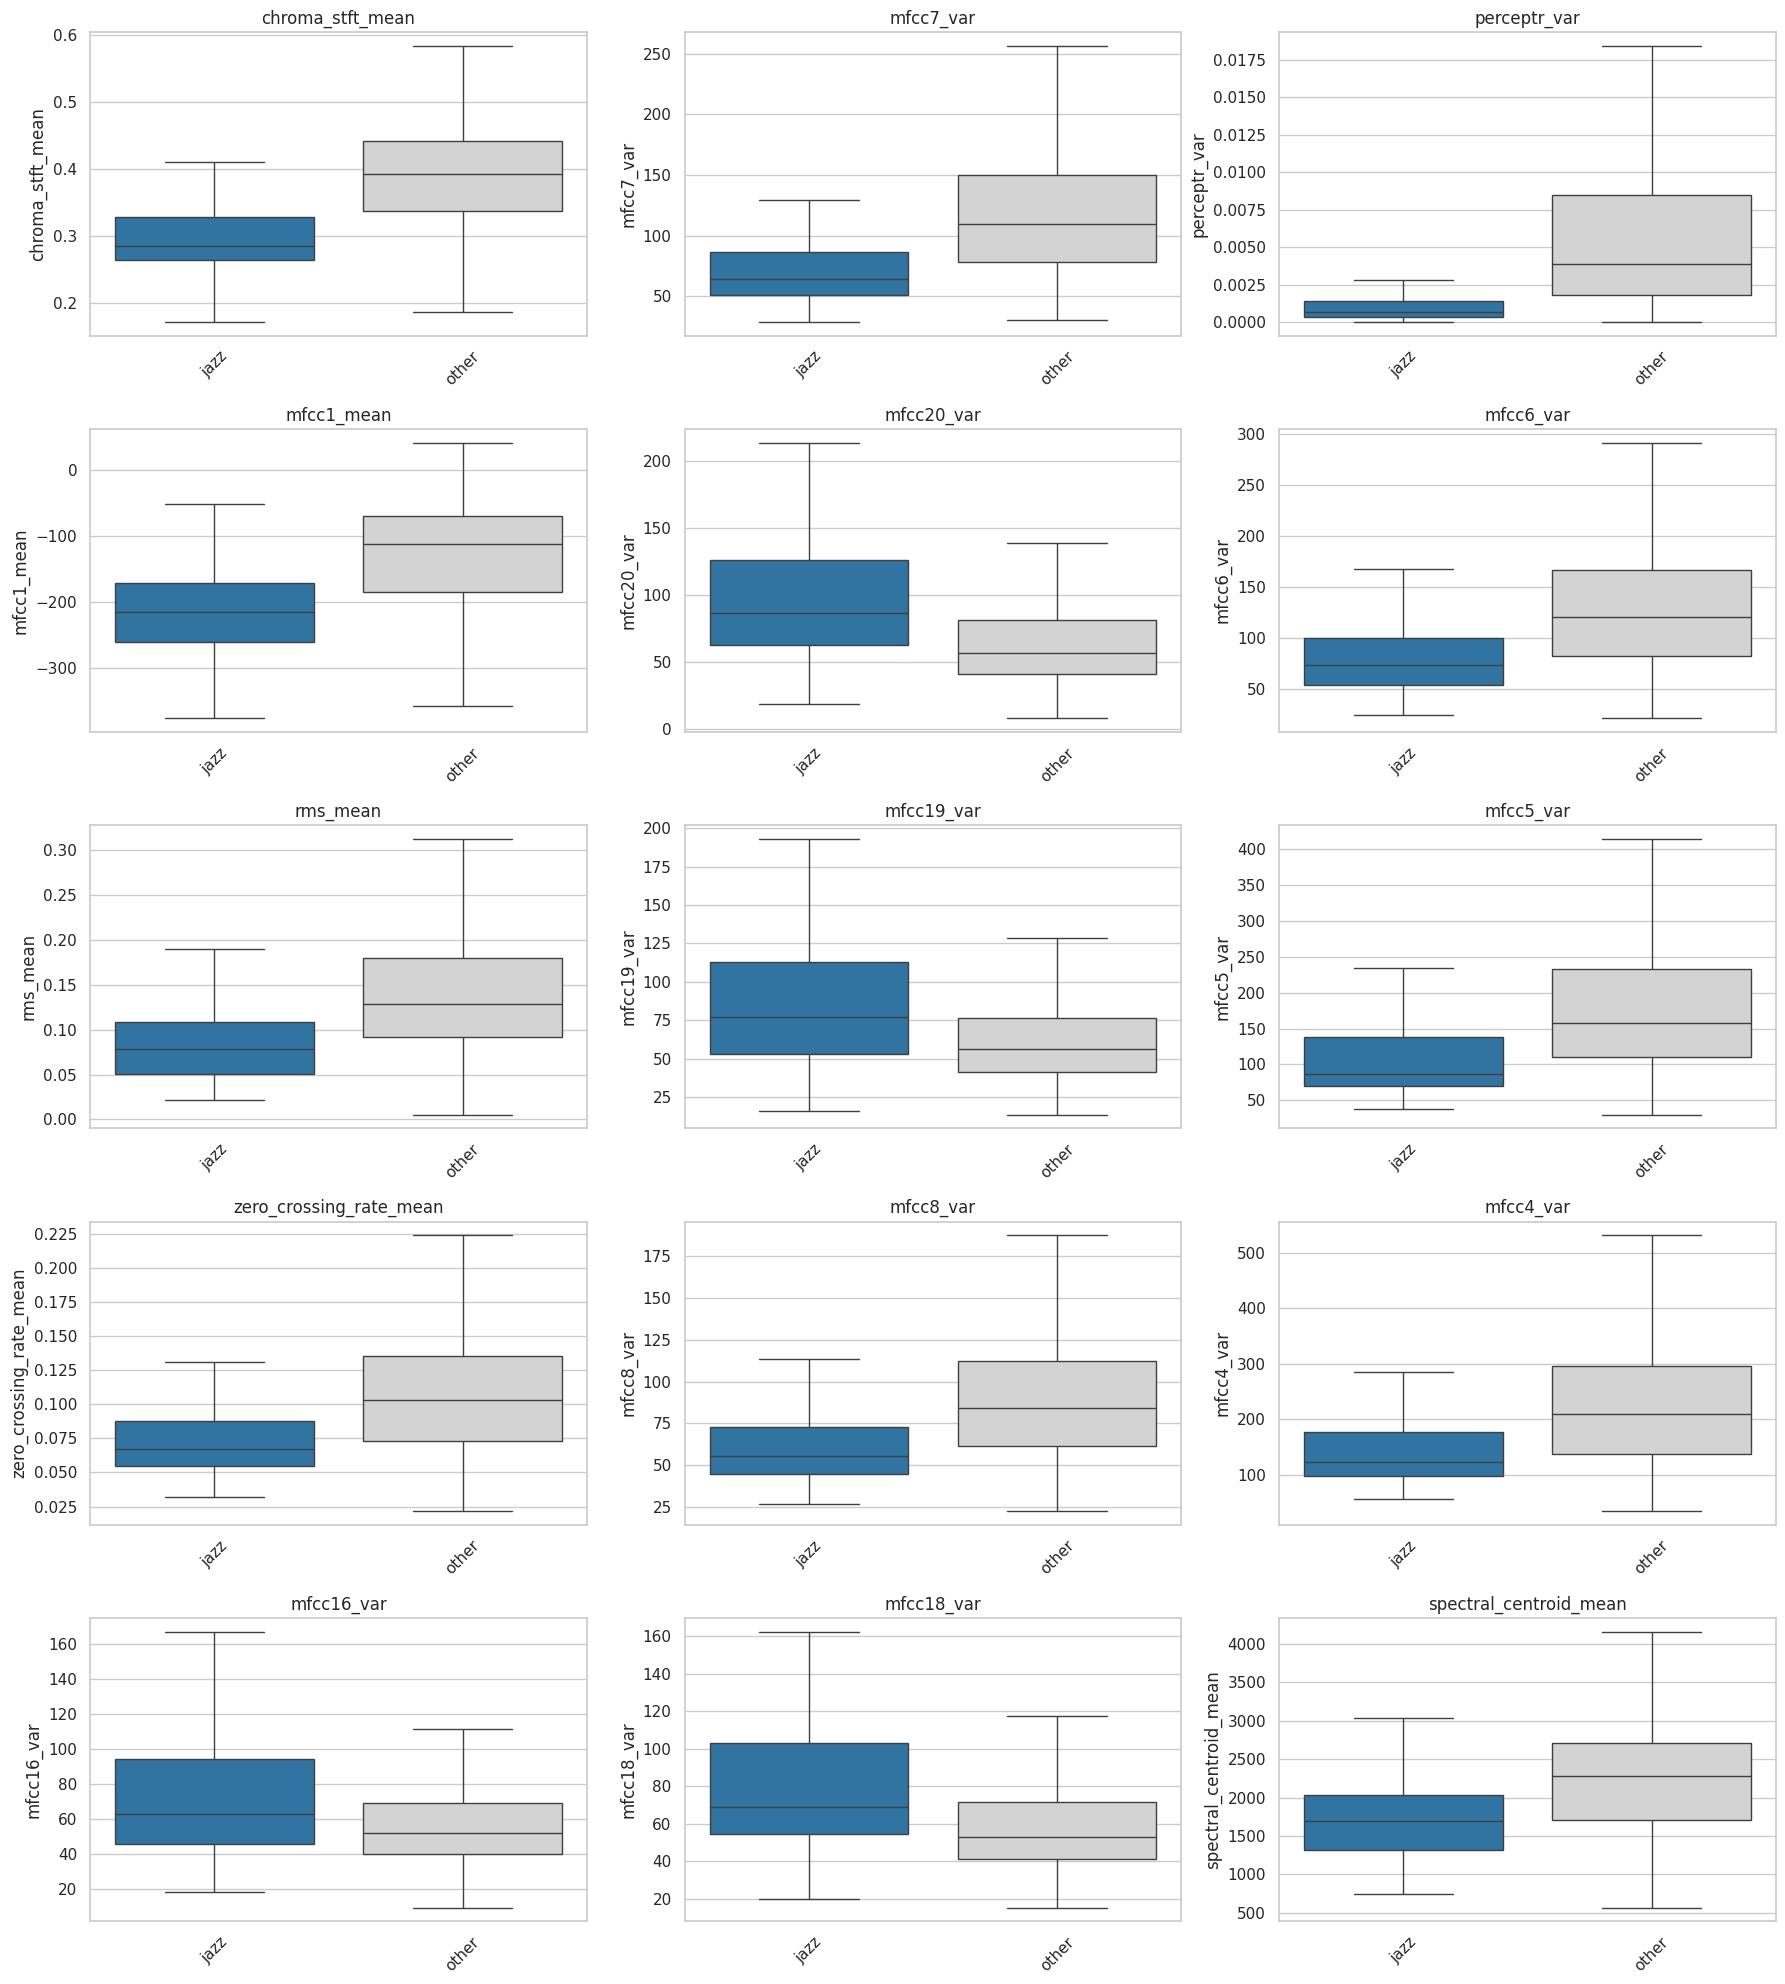

In [3]:

n_rows = int(np.ceil(len(top_features)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4))
axes = axes.flatten()

palette_dict = {target_genre: "tab:blue", "other": "lightgrey"}

for i, feat in enumerate(top_features):
    y_values = pd.concat([df_target[feat], df_rest[feat]])
    x_values = [target_genre]*len(df_target) + ["other"]*len(df_rest)
    
    sns.boxplot(
        x=x_values, y=y_values,
        hue=x_values,
        palette=palette_dict,
        showfliers=False,
        ax=axes[i],
        dodge=False,
        legend=False
    )
    
    axes[i].set_title(feat)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [4]:
from sklearn.model_selection import train_test_split

# wybieramy tylko próbki jazzu
target_genre = 'jazz'
df_target = df30[df30['label'] == target_genre]

# dzielimy na dwa zbiory
df_train, df_test = train_test_split(df_target, test_size=0.3, random_state=42)  

# obliczamy Q1 i Q3 dla top_features na zbiorze treningowym
quartiles = {}
for feature in top_features:
    Q1 = df_train[feature].quantile(0.25)
    Q3 = df_train[feature].quantile(0.75)
    quartiles[feature] = {"Q1": Q1, "Q3": Q3}

# konwertujemy na DataFrame dla czytelności
quartiles_df = pd.DataFrame(quartiles).T
print("Q1-Q3 na zbiorze treningowym jazzu:")
print(quartiles_df)

# df_test będzie naszym zbiorem testowym jazzu
print("\nLiczba próbek w zbiorze testowym jazzu:", len(df_test))


Q1-Q3 na zbiorze treningowym jazzu:
                                  Q1           Q3
chroma_stft_mean            0.266524     0.327893
mfcc7_var                  50.635916    83.279331
perceptr_var                0.000316     0.001432
mfcc1_mean               -259.147308  -169.386353
mfcc20_var                 65.150196   103.134455
mfcc6_var                  53.278609    93.482862
rms_mean                    0.049950     0.109772
mfcc19_var                 60.121000   109.178406
mfcc5_var                  70.111601   124.706182
zero_crossing_rate_mean     0.057862     0.094078
mfcc8_var                  44.105989    73.498249
mfcc4_var                  96.872828   172.499645
mfcc16_var                 44.562763    90.438950
mfcc18_var                 54.782160   102.477728
spectral_centroid_mean   1353.023660  2199.620416

Liczba próbek w zbiorze testowym jazzu: 30


In [5]:
def classify_jazz(samples, quartiles_df, features_to_use=None, threshold=5):
    """
    Klasyfikuje próbki jako 'jazz' lub 'other' na podstawie przedziałów Q1–Q3 wybranych cech.

    Args:
        samples (pd.DataFrame lub list[dict]): nowe próbki, kolumny = cechy
        quartiles_df (pd.DataFrame): tabela Q1-Q3 dla jazzu, indeks = nazwa cechy
        features_to_use (list[str], optional): lista cech do uwzględnienia. Domyślnie wszystkie cechy w quartiles_df.
        threshold (int): minimalna liczba cech mieszczących się w Q1-Q3, aby przypisać 'jazz'

    Returns:
        list[str]: lista predykcji dla każdej próbki ('jazz' lub 'other')
    """
    # jeśli lista słowników, konwertujemy na DataFrame
    if isinstance(samples, list):
        samples = pd.DataFrame(samples)
    
    # wybór cech
    if features_to_use is None:
        features = quartiles_df.index.tolist()
    else:
        # upewniamy się, że wybrane cechy są w tabeli kwartylowej
        features = [f for f in features_to_use if f in quartiles_df.index]
    
    predictions = []

    for _, row in samples.iterrows():
        score = 0
        for feat in features:
            if feat in row:
                value = row[feat]
                Q1 = quartiles_df.loc[feat, 'Q1']
                Q3 = quartiles_df.loc[feat, 'Q3']
                if Q1 <= value <= Q3:
                    score += 1
        prediction = 'jazz' if score >= threshold else 'other'
        predictions.append(prediction)
    
    return predictions


In [6]:
df_test_samples = df_test[top_features]
predictions = classify_jazz(df_test_samples, quartiles_df,top_features)
true_labels = ['jazz']*len(df_test_samples)  # wszystkie w zbiorze testowym są jazz
accuracy = sum([p==t for p,t in zip(predictions,true_labels)]) / len(true_labels)

print(f"\nDokładność klasyfikatora na zbiorze testowym jazzu: {accuracy:.2f}")


Dokładność klasyfikatora na zbiorze testowym jazzu: 0.80


In [7]:
top_features

['chroma_stft_mean',
 'mfcc7_var',
 'perceptr_var',
 'mfcc1_mean',
 'mfcc20_var',
 'mfcc6_var',
 'rms_mean',
 'mfcc19_var',
 'mfcc5_var',
 'zero_crossing_rate_mean',
 'mfcc8_var',
 'mfcc4_var',
 'mfcc16_var',
 'mfcc18_var',
 'spectral_centroid_mean']